In [22]:
#___________________________________________________________________________________________________________________
# # get_ipython().magic('matplotlib notebook')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
# %matplotlib inline
#%matplotlib notebook
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import pyvista as pv
import vtk
import tripyview as tpv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Parameters
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
save_path = '/albedo/home/pscholz/tripyview/Results/plot_3dsphere/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= 3
which_mode= '3dsphere'

#_____________________________________________________________________________________
input_paths= list()
input_paths.append(None)

input_names= list()
input_names.append('')

# vname     = 'nresol'
vname     = 'ndepth'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, 100

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None #'/home/ollie/pscholz/results/trr181_tke_ctrl_ck0.1/' # None
ref_name  = None #'TKE, ck=0.1' # None
ref_year  = None # [2009,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
do_clim   = False
which_clim= 'phc3'
clim_path = '/work/ollie/pscholz/INIT_HYDRO/phc3.0/phc3.0_annual.nc'

#_____________________________________________________________________________________
cmap      = 'rygbw'
cnum      = 20
cref      = None
crange, cmin, cmax, cfac = None, None, None, None

#_____________________________________________________________________________________
ncolumn       = 1 
do_rescale    = True
which_dpi     = 300
#_____________________________________________________________________________________
do_potatoefac = 0.6 # 0.6
do_topo       = False
do_nlinrescal = False 

In [24]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True,
                      do_earea=True, do_narea=True, do_eresol=[True,'mean'], do_nresol=[True,'eresol'])

#______________________________________________________________________________________________________
if which_cycl is not None: 
    for ii,ipath in enumerate(input_paths):
        if ipath is not None: 
            input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
            print(ii, input_paths[ii])
    
    if ref_path is not None:
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)
#______________________________________________________________________________________________________
cinfo=dict({'cstr':cmap, 'cnum':cnum})     
if crange   is not None: cinfo['crange']=crange
if cmin     is not None: cinfo['cmin'  ]=cmin
if cmax     is not None: cinfo['cmax'  ]=cmax
if cref     is not None: cinfo['cref'  ]=cref
if cfac     is not None: cinfo['cfac'  ]=cfac
if ref_path is not None: cinfo['cref'  ]=0.0    
    
#______________________________________________________________________________________________________
# in case of diff plots
if ref_path is not None:
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
 > comp. e_resol from mean
 > comp n_resol from e_resol
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, True
 > do narea,nresol = True, True
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


In [25]:
#___LOAD FESOM2 REFERENCE DATA________________________________________________________________________
if ref_path is not None:
    if depth =='bottom':
        data_ref = tpv.load_data_fesom2(mesh, ref_path, vname=vname, year=ref_year, mon=ref_mon, day=ref_day, record=ref_record, 
                                      depth=None, descript=ref_name, do_info=False) 
        data_ref = data_ref.isel(nz=xr.DataArray(mesh.n_iz, dims='nod2'), nod2=xr.DataArray(range(0,mesh.n2dn), dims='nod2'))
    else:
        data_ref = tpv.load_data_fesom2(mesh, ref_path, vname=vname, year=ref_year, mon=ref_mon, day=ref_day, record=ref_record, 
                                      depth=depth, descript=ref_name, do_info=False) 

#___LOAD FESOM2 DATA___________________________________________________________________________________
data_list = list()
for datapath,descript in zip(input_paths, input_names): 
    print(datapath)
    if depth =='bottom':
        data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, day=day, record=record, 
                                      depth=None, descript=descript, do_info=False) 
        data = data.isel(nz=xr.DataArray(mesh.n_iz, dims='nod2'), nod2=xr.DataArray(range(0,mesh.n2dn), dims='nod2'))
    else:
        data = tpv.load_data_fesom2(mesh, datapath, vname=vname, year=year, mon=mon, day=day, record=record, 
                                      depth=depth, descript=descript, do_info=False) 
    #__________________________________________________________________________________________________    
    if ref_path is not None:
        data_list.append(do_anomaly(data, data_ref))  
    else:
        data_list.append(data)  
    del(data)
    
if ref_path is not None: del(data_ref)    
    
#___APPEND ABS CLIMATOLOGY_____________________________________________________________________________    
if (vname in ['temp', 'salt', 'pdens'] or 'sigma' in vname) and (depth == 'bottom') and do_clim and (ref_path is None): 
    clim_vname = vname
    if   vname=='temp' and  which_clim.lower()=='woa18': clim_vname = 't00an1'
    elif vname=='salt' and  which_clim.lower()=='woa18': clim_vname = 's00an1'
    clim = tpv.load_climatology(mesh, clim_path, clim_vname, depth=depth)
    data_list.append(clim)    
    del(clim)

None


In [26]:
var = list(data_list[0].keys())[0]
print(data_list[0][var].values.max())
print(data_list[0][var].values.min())

6000.0
30.0


In [27]:
if do_nlinrescal:
    import copy as cp 
    # rescale resolusion nonlinear
    if 'resol' in vname:
        rescaling_vec = np.array([0,20,25,30,35,40,45,50,55,60,70,80,90,100,110,120,130,140,250])
        var = list(data_list[0].keys())[0]
        data_listrescal = cp.deepcopy(data_list)
        for ii in range(1,rescaling_vec.size-1):
            if ii==1:
                idx = np.where( data_list[0][var]<rescaling_vec[ii] )[0]
                data_listrescal[0][var].data[idx]=ii
            else:    
                idx = np.where( (data_list[0][var]>=rescaling_vec[ii-1]) & (data_list[0][var]<rescaling_vec[ii]) )[0]
                data_listrescal[0][var].data[idx]=ii + (data_listrescal[0][var].data[idx]-rescaling_vec[ii])/(rescaling_vec[ii]-rescaling_vec[ii-1])

            if ii == rescaling_vec.size-2:
                idx = np.where( data_list[0][var]>=rescaling_vec[ii] )[0]
                data_listrescal[0][var].data[idx]=ii
        data_list = data_listrescal
        print(data_list[0][var].values.max())
        print(data_list[0][var].values.min())

In [28]:
#
#
#___CREATE PYVISTA OCEAN MESH___________________________________________________________
meshpv_ocean = tpv.create_3dsphere_ocean_mesh(mesh, data_list[0], potatoefac=do_potatoefac, variable=vname)

#
#
#___CREATE PYVISTA LAND MESH TO FILL HOLES______________________________________________
# # meshpv_land = create_3d_land_mesh(mesh)
meshpv_land = tpv.create_3dsphere_land_mesh(mesh,
                                  potatoefac  = 0.25,
                                  resol       = 0.5,
                                  do_topo     = do_topo, 
                                  topo_path   = '/home/pscholz/AWI/AWI_DATA/data_ETOPO5/topo_1deg.nc', #'/home/pscholz/AWI/AWI_DATA/data_ETOPO5/topo_1deg.nc',
                                  topo_varname= 'topo',
                                  topo_dimname= ['lon','lat'])
#
#
#___CREATE PYVISTA 3d COASTLINE, LONLAT GRID____________________________________________
points_coast         = tpv.create_3dsphere_coastline(mesh)    
points_lonlat_grid   = tpv.create_3dsphere_lonlat_grid(dlon=20,dlat=15,potatoefac=0.25,do_topo=do_topo)
points_0lon0lat_grid = tpv.create_3dsphere_0lon0lat_grid(dlon=20,dlat=15,potatoefac=0.25,do_topo=do_topo)

 --> compute 3d ocean mesh
 --> compute 3d land mesh
 --> compute 3d coastline
 --> compute 3d longitude grid
 --> compute 3d latitude grid
 --> compute 3d equator & 0merid line


ntopo
{'crange': [0, 6000, 3000], 'cstr': 'wbgyr', 'cnum': 20, 'chist': True, 'ctresh': 0.995, 'cmin': 0, 'cmax': 6000, 'cref': 3000, 'cmap': <matplotlib.colors.ListedColormap object at 0x7fbff10ecca0>, 'clevel': array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.,
       2250., 2500., 2750., 3000., 3250., 3500., 3750., 4000., 4250.,
       4500., 4750., 5000., 5250., 5500., 5750., 6000.])}
[0.0, 6000.0]
--> draw ocean mesh
--> draw land mesh
--> draw coast lines
--> draw grid lines 
--> print screenshot
/albedo/home/pscholz/tripyview/Results/plot_3dsphere/


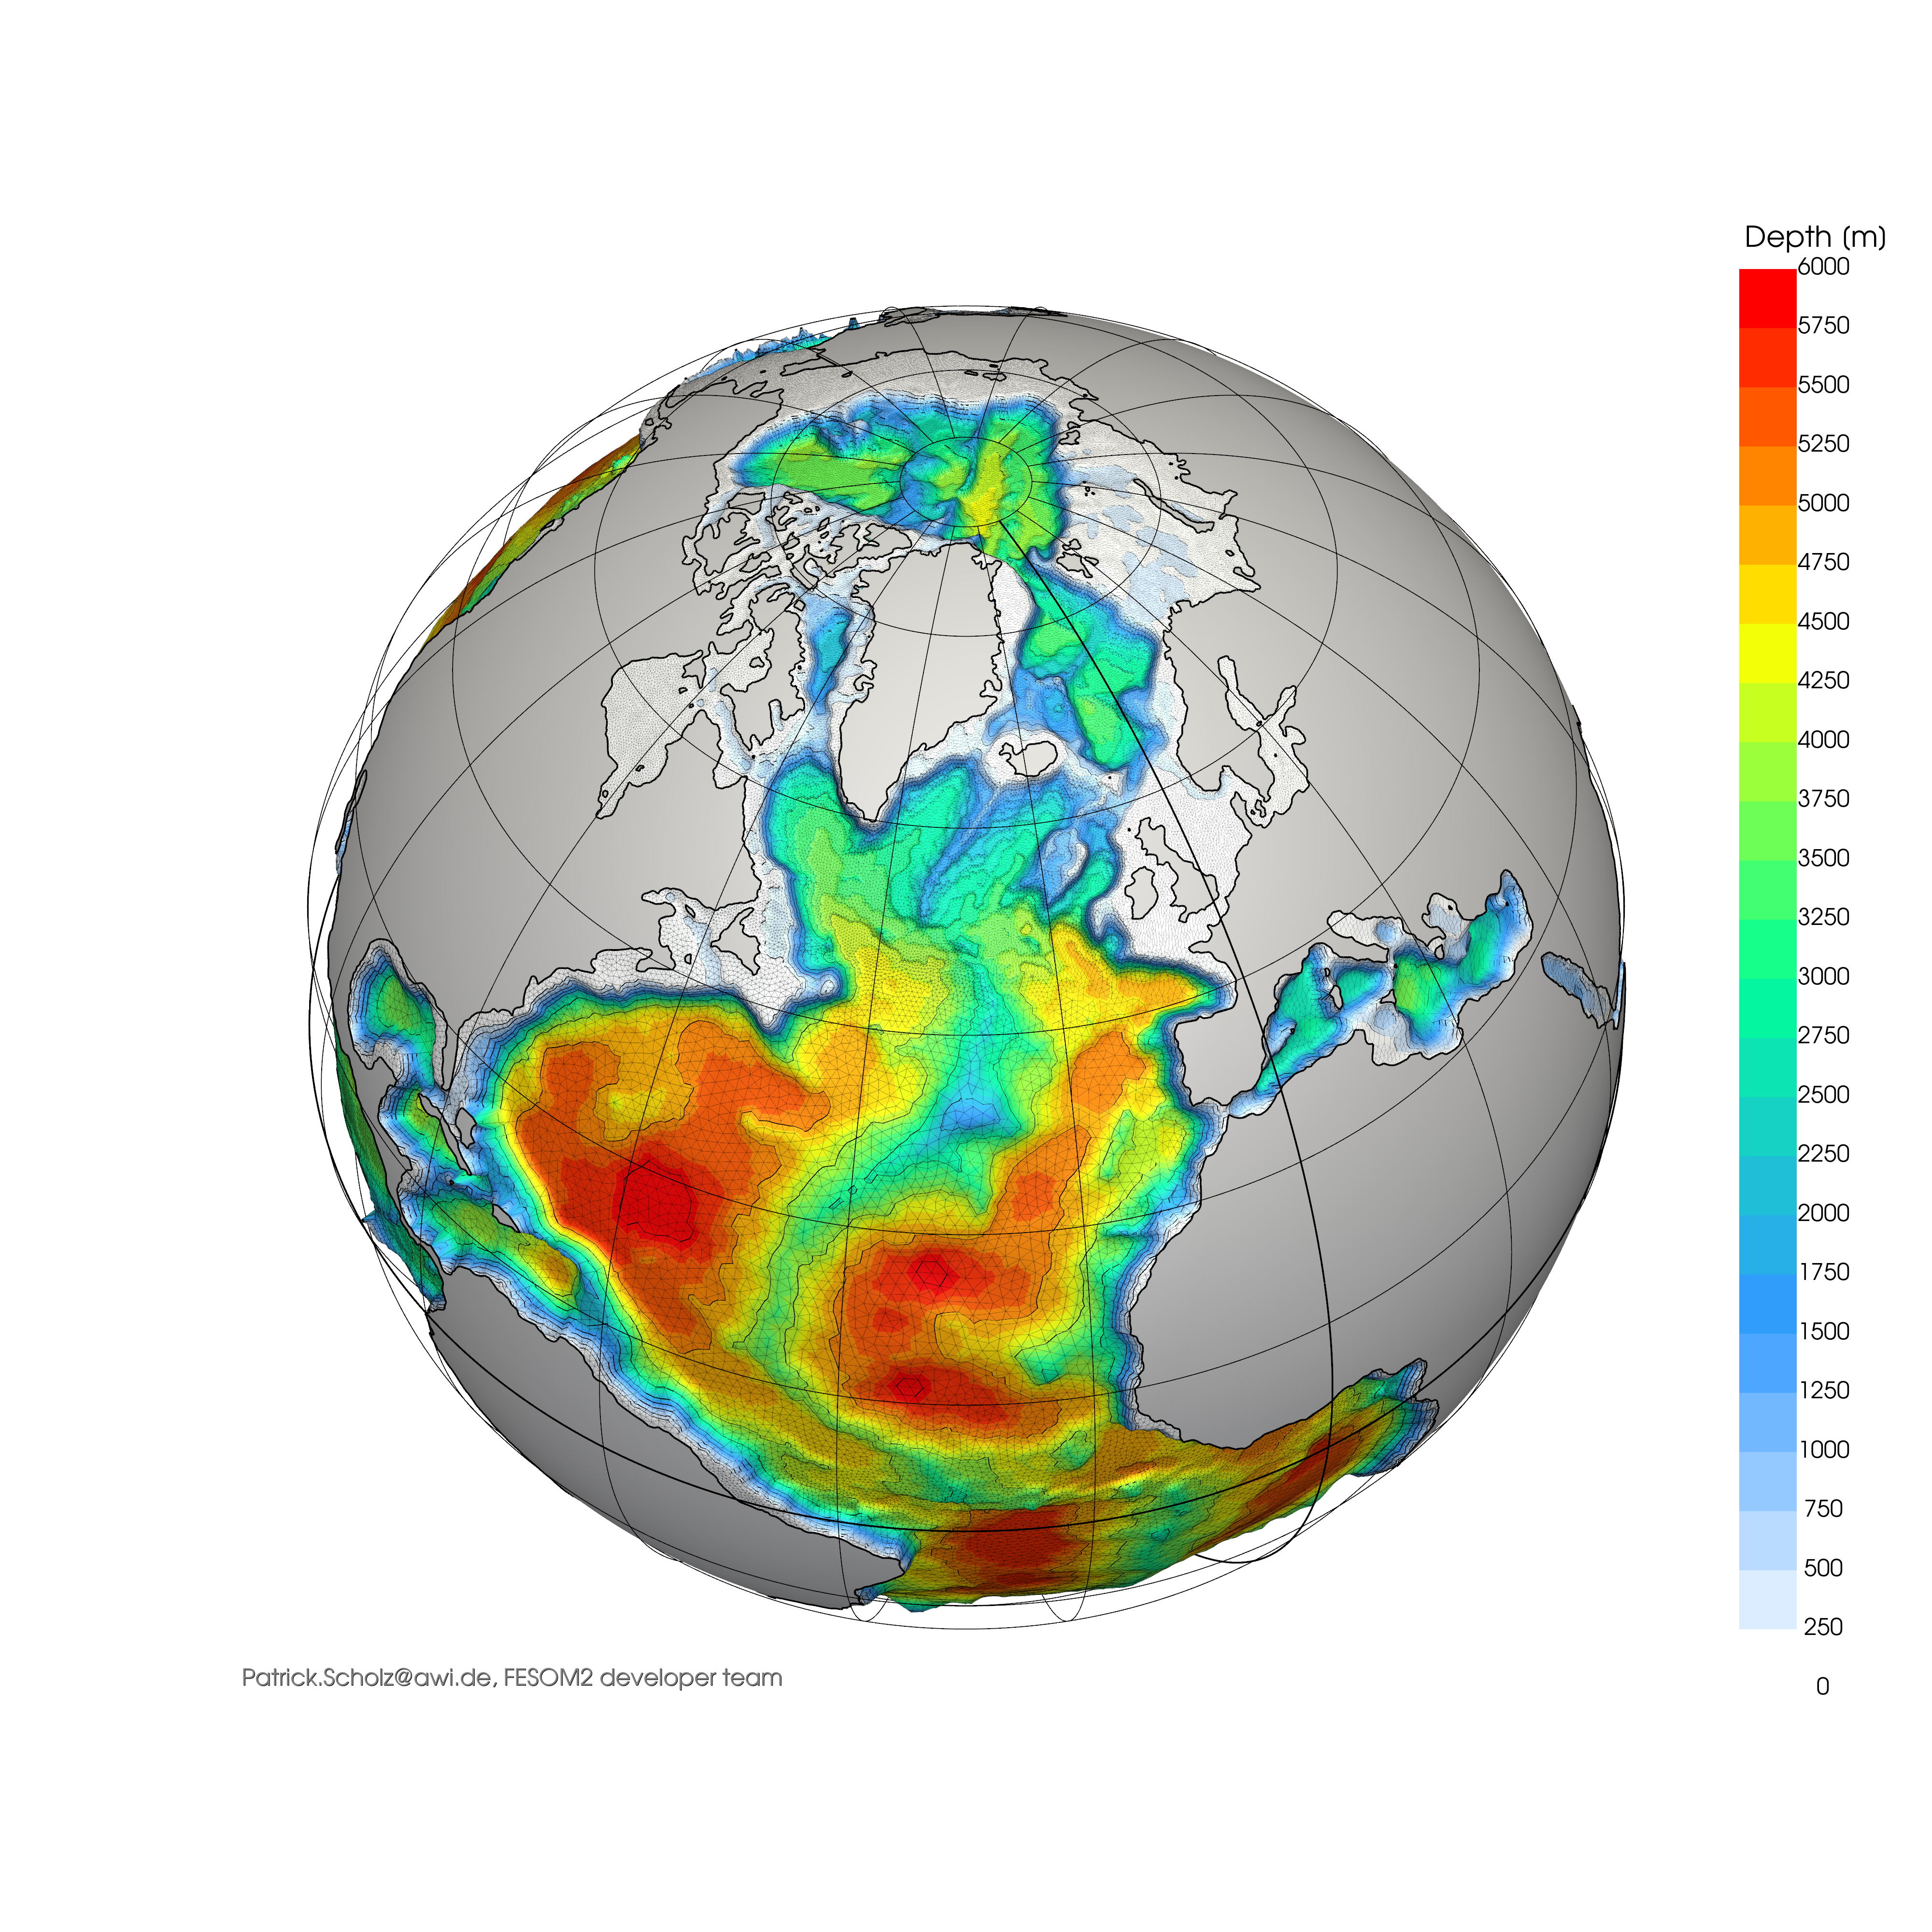

In [30]:
#___CREATE PYVISTA OCEAN MESH___________________________________________________________
# do_mode    = 'interactive' # 'interactive', 'movie', 'print'
# do_mode    = 'movie' # 'interactive', 'movie', 'print'
do_mode    = 'print' # 'interactive', 'movie', 'print'
do_contour = True
do_gridline= True
do_showedge= True
do_smooth  = True
init_lon, init_lat, init_zoom = -30, 50, 1.75 #2
# init_lon, init_lat, init_zoom = 150, 15, 1.75 #2
# init_lon, init_lat, init_zoom = 0, 90, 1.75 #2

# lightning options
diffuse        = 0.4 #0.25
specular       = 0.1 #0.25 
specular_power = 2
ambient        = 0.25 #0.3
metallic       = 0
roughness      = 0

# land texture options
do_landtexture= False
landcolor     = [0.8, 0.8, 0.8]
texture_file  = 'world.topo.bathy.200408.3x5400x2700.png'
texture_path  = os.path.join(tpv.__path__[0], 'backgrounds/')

#_______________________________________________________________________________________
# create custom colormap
vname = list(data_list[0].keys())[0]
print(vname)
cinfo = dict()
if any(x in vname for x in ['depth','topo','topography','zcoord']):  
    cinfo['crange'], cinfo['cstr'], cinfo['cnum'] = [0, 6000, 3000], 'wbgyr', 20
    
elif any(x in vname for x in ['nresol','n_resol','resolution','resol']):
    if do_nlinrescal:
        cinfo['cstr'  ] = 'rygbw'
        cinfo['crange'] = [0, rescaling_vec.size-1, np.ceil(rescaling_vec.size/2)]
        cinfo['cnum'  ] = rescaling_vec.size-1
    else:
        cinfo['cstr'  ] = 'rygbw'
        cinfo['crange'] = [20, 140, 60]
        cinfo['cnum'  ] = 15
cinfo = tpv.do_setupcinfo(cinfo, data_list, None, mesh, False)
clim = [cinfo['clevel'][0],cinfo['clevel'][-1]]
print(clim)

#_______________________________________________________________________________________
# create colorbar string
cbar_label, cbar_unit = None, None
if cbar_label is None     : cbar_label = data_list[0][vname].attrs['long_name']
if cbar_unit  is None     : cbar_label = cbar_label+' ['+data_list[0][ vname ].attrs['units']+']'
else                      : cbar_label = cbar_label+' ['+cbar_unit+']'
if 'str_ltim' in data_list[0][vname].attrs.keys(): cbar_label = cbar_label+'\n'+data_list[0][vname].attrs['str_ltim']
if 'str_ldep' in data_list[0][vname].attrs.keys(): cbar_label = cbar_label+data_list[0][vname].attrs['str_ldep']

#_______________________________________________________________________________________
# create pyvista plot object
# pv.set_plot_theme("default")
pv.set_plot_theme("document")
# pv.set_plot_theme("dark")
# pv.set_plot_theme("ParaView")

fsize_label, fsize_title, linew1 = 12, 24, 2
if do_mode=='print':
    do_wsize   = [4000,4000]
    pv.set_plot_theme("document")
    plt = pv.Plotter(notebook=True, off_screen=False, window_size=do_wsize, 
                     multi_samples=4, line_smoothing=True, polygon_smoothing=True,)
    plt.background_color=None
    fsize_label, fsize_title = fsize_label*4, np.int16(fsize_title*2.5)
    fsize_author=24
    
elif do_mode=='movie':
    do_wsize = [1000,1000]
    plt = pv.Plotter(notebook=True, window_size=do_wsize, 
                     multi_samples=4, line_smoothing=True, polygon_smoothing=True)    
    fsize_label, fsize_title = fsize_label*2, np.int16(fsize_title*1.5)
    fsize_author=18
    linew1 = 2
    
elif do_mode=='interactive':
    do_wsize = [1000,1000]
    plt = pv.Plotter(notebook=True, window_size=do_wsize,
                    multi_samples=4, line_smoothing=True, polygon_smoothing=True)
    fsize_label, fsize_title = fsize_label, np.int16(fsize_title)
    linew1 = 1
    fsize_author=10

#_______________________________________________________________________________________
# set up colorbar and labels in case of non-linear rescaling 
which_fmt = "%4.0f"
dict_annot=dict()
if do_nlinrescal:
    which_fmt=''
    for ii,vv in enumerate(rescaling_vec):
        if   ii==0                   : dict_annot.update({ ii:' '})
        elif ii==rescaling_vec.size-1: dict_annot.update({ ii:' '})
        else                         : dict_annot.update({ ii:f'{vv} km'})

dict_sargs = dict(
             title          = cbar_label,    
             vertical       = True, height=0.75, position_x=0.9, position_y=0.125,
             shadow         = True,
             title_font_size= fsize_title,
             label_font_size= fsize_label,
             fmt            = which_fmt,
             n_labels       = np.int8(len(cinfo['clevel'])),#n_labels=np.int8(len(clevel)/2)+1,
             n_colors       = cinfo['cmap'].N,
             outline        = False)

#_______________________________________________________________________________________
# plot 3d ocean mesh
print('--> draw ocean mesh')
plt.add_mesh(meshpv_ocean, 
             scalars         = vname, 
             clim            = clim,
             cmap            = cinfo['cmap'], n_colors=cinfo['cmap'].N,
             show_edges      = False, 
             edge_color      = 'black',
             show_scalar_bar = True, 
             scalar_bar_args = dict_sargs,
             diffuse         = diffuse, 
             specular        = specular, 
             specular_power  = specular_power, 
             ambient         = ambient,
             annotations     = dict_annot,
             smooth_shading  = do_smooth)

if do_showedge:
    # Extract the edges and create an actor for them
    edges = meshpv_ocean.extract_all_edges()
    edge_actor = plt.add_mesh(edges,color='black', line_width=2, )
    edge_actor.GetProperty().SetOpacity(0.25)  # Adjust the alpha value as needed

if do_contour:
    contours = meshpv_ocean.contour(scalars='ntopo', isosurfaces = np.array([250,500,1000,1500,2000,3000,4000,5000,6000]))
    plt.add_mesh(contours, 
                 color          = "black", 
                 line_width     = 2, 
                 smooth_shading = True, 
                 diffuse        = diffuse, 
                 specular       = specular, 
                 specular_power = specular_power, 
                 ambient        = ambient,
                 lighting       = True)
    del contours
    
#_______________________________________________________________________________________
# plot 3d land mesh
print('--> draw land mesh')
texture=None
if do_landtexture: 
    texture   = pv.read_texture(os.path.join(texture_path, texture_file))
    landcolor = [0.99, 0.99, 0.99]
    diffuse, specular, specular_power, ambient = 0.65, 0.2, 5, 0.65

plt.add_mesh(meshpv_land, 
             color         = landcolor, 
             texture       = texture, 
             smooth_shading= do_smooth,
             diffuse       = diffuse, 
             specular      = specular, 
             specular_power= specular_power, 
             ambient       = ambient)
# if do_contour and do_topo: # --> needs some tweeking/smoothing of the contourslines 
#     contours = meshpv_land.contour(scalars='topo', isosurfaces=np.array([1000,2000,4000]))
#     plt.add_mesh(contours, color="w", line_width=3, smooth_shading=True)
#     del contours

if do_mode =='movie':
    plt.add_text('Patrick.Scholz@awi.de, FESOM2 developer team',position=[1, 1], #position='upper_right', 
             font_size=fsize_author, color=[0.5, 0.5, 0.5], shadow=True)         
else:     
    plt.add_text('Patrick.Scholz@awi.de, FESOM2 developer team',position=[0.125*do_wsize[0], 0.125*do_wsize[1]], #position='upper_right', 
             font_size=fsize_author, color=[0.5, 0.5, 0.5], shadow=True)         

#_______________________________________________________________________________________
# plot 3d coast, lon-grid and lat-grid lines
print('--> draw coast lines')
for points in points_coast        : plt.add_lines(points, color='black',width=linew1*2)
if do_gridline: 
    print('--> draw grid lines ')    
    for points in points_lonlat_grid  : plt.add_lines(points, color='black', width=linew1)
    for points in points_0lon0lat_grid: plt.add_lines(points, color='black', width=linew1*2)

#_______________________________________________________________________________________ 
# add specific light to scene
light = pv.Light(light_type='headlight')
light.intensity = 1.0
plt.add_light(light)

#_______________________________________________________________________________________
# do slider widget infrastructure for interactive plotting
R_earth    =  6371.0e3
if do_mode == 'interactive':
    wgap    = 0.05 
    wslider = (1-4*wgap)/3
    engine  = tpv.widget_lon_lat_zoom(plt, init_lon,init_lat,init_zoom)
    
    slid1=plt.add_slider_widget(lambda value: engine(plt, 'center_lon', int(value)), 
                          [-180, 180], value = int(init_lon), title='lon', style='modern', title_opacity=0.5,fmt="%3.0f",
                          pointa=(1*wgap+0*wslider, .06), pointb=(1*wgap+1*wslider, .06))
    slid2=plt.add_slider_widget(lambda value: engine(plt, 'center_lat', int(value)),
                          [ -90,  90], value =  int(init_lat), title='lat', style='modern' , title_opacity=0.5,fmt="%3.0f",
                          pointa=(2*wgap+wslider, .06),   pointb=(2*wgap+2*wslider, .06))
    slid3=plt.add_slider_widget(lambda value: engine(plt, 'zoom_fac',   value),
                          [0.1,  10],   value =  init_zoom,  title='zoom_fac', style='modern', title_opacity=0.5,fmt="%2.1f",
                          pointa=(3*wgap+2*wslider, .06), pointb=(3*wgap+3*wslider, .06))
    plt.show(jupyter_backend='trame', window_size=do_wsize )
    # plt.export_html(os.path.join(save_path,'test.html'))

#_______________________________________________________________________________________
# do animated mp4 of rotating earth 
elif do_mode =='movie':
    frame_nr    = 100 #720
    frame_rate  = 16 # window size must be a multiple of 16 --> ffmpeg rule?!
    frame_fac   = 120 # 25(400x400), 50(800x800), 120(1920x1920)
    frame_wsize = [frame_rate*frame_fac, frame_rate*frame_fac]
    fname       = 'movie_3dsphere_{}_{:d}x{:d}.mp4'.format(vname, frame_wsize[0], frame_wsize[1])
    plt.open_movie(os.path.join(save_path,fname), framerate=frame_rate)
    
    #___________________________________________________________________________________
    # define camera pathway
    rad          = np.pi/180
    lat_max      = 75
    lon_s, lat_s = -30, 45
    frame_lon    = np.linspace(0+lon_s, 720+lon_s, frame_nr+1)
    frame_lat    = -np.sin(np.linspace(-180, 180, frame_nr+1)*rad + np.arcsin(lat_s/lat_max) )*lat_max
    # frame_lat = -np.tanh(np.linspace(-360,360,360)*0.2)*45
    
    #___________________________________________________________________________________
    x,y,z = tpv.grid_cart3d(frame_lon[0], frame_lat[0], R_earth*10/2)
    plt.camera_position = [ np.array([x,y,z]), (0,0,0), (0,0,1)] 
    # plt.show(jupyter_backend='trame', auto_close=False, interactive_update=True, window_size=frame_wsize)
    plt.show(jupyter_backend='trame', window_size=frame_wsize)
    for iframe in range(0,frame_nr):
        x,y,z = tpv.grid_cart3d(frame_lon[iframe], frame_lat[iframe], R_earth*10/1.8, is_deg=True)
        plt.camera_position = [ np.array([x,y,z]), (0,0,0), (0,0,1)] 
        # plt.update()
        plt.write_frame()
    # plt.close()
    
#_______________________________________________________________________________________
# do save as png
# https://nbviewer.org/github/banesullivan/damavand-volcano/blob/master/Damavand_Volcano.ipynb
elif do_mode =='print':   
    fname = 'image_3dsphere_{:s}_lon{:03d}_lat{:03d}.png'.format(vname, init_lon, init_lat)
    x,y,z = tpv.grid_cart3d(init_lon, init_lat, R_earth*10/1.8, is_deg=True)
    plt.camera_position = [ np.array([x,y,z]), (0,0,0), (0,0,1)] 
    print('--> print screenshot')
    #_______________________________________________________________________
    if not os.path.isdir(save_path): os.makedirs(save_path)
    print(save_path)    
    plt.screenshot(filename=os.path.join(save_path,fname), window_size=do_wsize, transparent_background=True)
    plt.show(jupyter_backend='static')